# Lab 5.3: Two Sample Hypothesis Testing

**Question 1**

 Many doctors believe that early prenatal care is very important to the health of a baby and its mother. Efforts have recently been focused on teen mothers. A random sample of 52 teenagers who gave birth revealed that 32 of them began prenatal care in the first trimester of their pregnancy. A random sample of 209 women in their twenties who gave birth revealed that 163 of them began prenatal care in the first trimester of their pregnancy.  
 
1) Construct a 95% confidence interval for the difference between the proportion of teen mothers who get early prenatal care and the proportion of mothers in their twenties who get early prenatal care.  


2) Briefly interpret the confidence interval. 

In [1]:
%pylab inline
import pandas as pd
import yaml

from scipy import stats
from sqlalchemy import create_engine
from statsmodels.stats.weightstats import ttest_ind

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))

Populating the interactive namespace from numpy and matplotlib


### 1

In [2]:
p_1 = 32/52
p_2 = 163/209
calculation = stats.norm.ppf(0.975) * ((p_1)*(1-p_1)/52 + (p_2)*(1-p_2)/209)**0.5
print("Confidence interval is:", (p_1 - p_2) - calculation, (p_1 - p_2) + calculation)

Confidence interval is: -0.308186125116 -0.0208532565554


### 2
The confidence interval does not include 0, so we conclude that the proportion of teen mothers who get ear;y prenatal care is lower than the proportion of mothers in their twenties.

**Question 2**  

A math instructor wrote two versions of the same test that he believed to be of equal difficulty. He gave the first version (A) to 36 students and the second version (B) to 41 students. We will consider the two groups to be random samples from the population of all community college statistics students. The 36 students who took version A had a mean score of 79.3 with a standard deviation of 11.26. The 41 students who took version B had a mean score of 84.1 with a standard deviation of 9.40.  

1) Construct a 95% confidence interval for the difference between the mean score of version A and the mean score of version B.  


2) Interpret the confidence interval in context. 

### 1

In [3]:
# We use the confidence interval formula for large samples.
diff_means = 79.3 - 84.1
calculation = stats.norm.ppf(0.975) * ((11.26**2)/36 + (9.40**2)/41)**0.5
print("Confidence interval is:", diff_means - calculation, diff_means + calculation)

Confidence interval is: -9.46989942976 -0.130100570244


### 2

The interval does not contain 0, so we conclude that they are not of equally difficulty, in fact test A is harder.

**Question 3**  

A group of 18 concertgoers was selected at random. Before the concert they were given a hearing test, and then were given another one after the concert. (The volume varied during the test, and the person also had to state which ear the sound was in.) The number of correctly identified sounds out of 10, both before and after the concert, can be found in the `before` and `after` tables in RDS (hint: join `USING (goer_id);`).  

1) Construct a 95% confidence interval for the mean of the differences between the scores before the concert and the scores after the concert.  


2) At the 0.05 level of significance, test whether a person’s hearing is adversely affected by the noise of a concert. 

### 1

In [4]:
before_after = pd.read_sql("SELECT before.goer_id, before.hearing AS before_hearing, after.hearing AS after_hearing, (after.hearing - before.hearing) AS difference_hearing FROM before INNER JOIN after ON before.goer_id = after.goer_id", engine)

In [5]:
before_after.head()

,goer_id,before_hearing,after_hearing,difference_hearing
0,0,9,8,-1
1,1,10,8,-2
2,2,9,9,0
3,3,8,6,-2
4,4,8,6,-2


In [6]:
diff_means = before_after['difference_hearing'].mean()
s_error = before_after['difference_hearing'].std()/len(before_after)**0.5
calculation = stats.t(len(before_after)-1).ppf(0.975) * s_error
print("Confidence interval is:", diff_means - calculation, diff_means + calculation)

Confidence interval is: -1.87297071713 -0.571473727313


### 2

$\alpha$ = 0.05

$H_0$ = 0

$H_a$ < 0

In [7]:
t_stat_hearing = (diff_means - 0)/(before_after['difference_hearing'].std()/len(before_after)**0.5)
t_stat_hearing

-3.9626115222585065

In [8]:
p_value_hearing = stats.t(len(before_after)-1).cdf(t_stat_hearing)
p_value_hearing

0.00050273317937768122

The p-value is less than 0.05, therefore, we have enough evidence to reject the null hypothesis that hearing is not adversely affected.

**Question 4**

Are male high school graduates equally likely to attend college the following fall as female high school graduates? A random sample of 1354 males who graduated high school in 2007 found that 860 of them were enrolled in college in October 2007. A sample of 1415 females who graduated high school in 2007 found that 995 of them were enrolled in college in October 2007. At the 0.05 level of significance, test the null hypothesis that the proportion of male graduates that go on to college is the same as the proportion of female graduates that go on to college against the two sided alternative. Clearly state your conclusion. 

In [9]:
p_1 = 860/1354
p_2 = 995/1415

$H_0$ = p_1 - p_2 = 0

$H_a$ = p_1 - p_2 $\neq$ 0

In [10]:
p_hat = (1354 * p_1 + 1415 * p_2)/(1354 + 1415)

In [11]:
z_stat = (p_1 - p_2)/(p_hat * (1 - p_hat) * ((1/1354) + (1/1415)))**0.5

In [12]:
# It's a two sided test.
p_value_school = stats.norm().cdf(z_stat) * 2
p_value_school

0.00014171083233362821

The p-value is less than 0.05, therefore there's enough evidence to reject the null hypothesis that the proportion of male and female graduates that go to college is equal.

**Question 5**

Here we will use hypothesis testing to analyze **Click Through Rate (CTR)** on the New York Times website.
Click-through rate (CTR) is the number of users that click on a specific link out of the total users that view a page, email, or advertisement.
We are going to determine if there is statistically significant difference between the mean CTR for
the following groups:
```
1. Signed in users v.s. Not signed in users
2. Male v.s. Female
```


1) Load the `nyt` table from RDS into a pandas dataframe.

   Use `data.info()` to make sure the datatypes are valid and there are no null values.
   This data has been cleaned for you, but generally it is good practice to check for those.
   

In [13]:
ctr = pd.read_sql("SELECT * FROM nyt", engine)

In [14]:
ctr.head()

,user_id,age,gender,impressions,clicks,signed_in
0,0,36,0,3,0,1
1,1,73,1,3,0,1
2,2,30,0,3,0,1
3,3,49,1,3,0,1
4,4,47,1,11,0,1


In [15]:
ctr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458441 entries, 0 to 458440
Data columns (total 6 columns):
user_id        458441 non-null int64
age            458441 non-null int64
gender         458441 non-null int64
impressions    458441 non-null int64
clicks         458441 non-null int64
signed_in      458441 non-null int64
dtypes: int64(6)
memory usage: 21.0 MB


2) Make a new column `CTR` using the `Impressions` and the `Clicks` columns. (`CTR` = `Clicks` / `Impressions`)  
   Remember to remove the rows with `0` impressions.
   

In [16]:
ctr['CTR'] = ctr['clicks']/ctr['impressions']

In [17]:
ctr.head()

,user_id,age,gender,impressions,clicks,signed_in,CTR
0,0,36,0,3,0,1,0.0
1,1,73,1,3,0,1,0.0
2,2,30,0,3,0,1,0.0
3,3,49,1,3,0,1,0.0
4,4,47,1,11,0,1,0.0


In [18]:
ctr_not_null = ctr[ctr['impressions'] > 0]

In [19]:
len(ctr_not_null)

455375

3) Plot the distribution of each column in the dataframe. You can do this using `pandas.DataFrame.hist()`.
   Check out the arguments you can use with the function
   [here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.hist.html).
   Set the `figsize=(12,5)` to make sure the graph is readable.
   

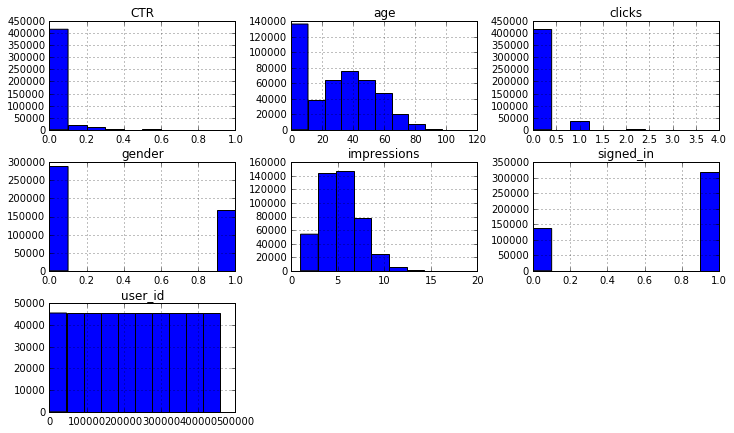

In [20]:
pd.DataFrame.hist(ctr_not_null, figsize=(12,7));

4) Make 2 dataframes separating the rows where the users who are signed in and users who are
   not signed in.
   Plot the distributions of the columns in each of the dataframes. By visually inspecting
   the two sets of distributions, describe the differences between users who are signed in and not signed in?

In [21]:
sign_in = ctr_not_null[ctr_not_null['signed_in'] == 1]

In [22]:
not_sign_in = ctr_not_null[ctr_not_null['signed_in'] == 0]

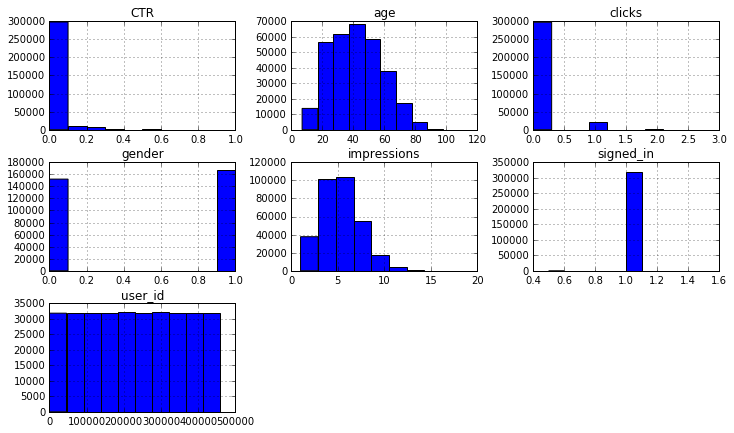

In [23]:
pd.DataFrame.hist(sign_in, figsize=(12,7));

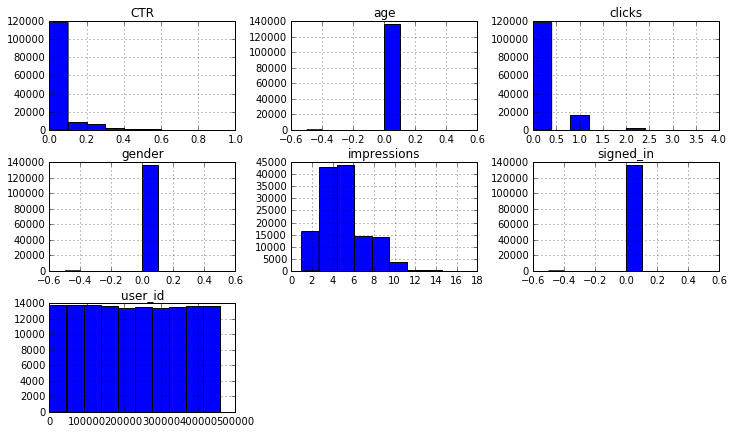

In [24]:
pd.DataFrame.hist(not_sign_in, figsize=(12,7));

In [25]:
print("Signed in users:", len(sign_in), "Not signed in users:", len(not_sign_in))

Signed in users: 319198 Not signed in users: 136177


Age and gender are not collected when the user is signed out.

The signed_in attribut is either 0 or 1 with the corresponding dataset.

The distributions of user_id, clicks, impressions and CTR appear visually similar.

5) Use a Welch's t-test to determine if the mean CTR between the signed-in users
   and the non-signed-in users is statistically different. Explain how you
   arrive at your conclusion.

   The Welch's t-test assumes the two populations in which the samples are drawn from
   have different variances.

   ```python
   scipy.stats.ttest_ind(a, b, equal_var=False)
   ```

In [26]:
stats.ttest_ind(sign_in['CTR'], not_sign_in['CTR'], equal_var=False)

Ttest_indResult(statistic=-55.376117934260868, pvalue=0.0)

$H_0$ = the mean CTR of users signed in - the mean CTR of users signed out = 0

$H_a$ = the mean CTR of users signed in - the mean CTR of users signed out $\neq$ 0

$\alpha$ = 0.05

The p-value is less than 0.05, therefore, there's enough evidence to reject the null hypothesis that the CTR of users who are signed in is equal to the CTR of users who are signed out.


6) Determine if the mean CTR between male users and female users is
   statistically different. `Male: 1, Female: 0`


In [27]:
male = ctr_not_null[ctr_not_null['gender'] == 1]

In [28]:
female = ctr_not_null[ctr_not_null['gender'] == 0]

In [29]:
stats.ttest_ind(male['CTR'], female['CTR'], equal_var=False)

Ttest_indResult(statistic=-35.874129799254021, pvalue=2.1289369889958908e-281)

$H_0$ = the mean CTR of male users - the mean CTR of female users = 0

$H_a$ = the mean CTR of male users - the mean CTR of female users $\neq$ 0

$\alpha$ = 0.05

The p-value is less than 0.05, therefore, there's enough evidence to reject the null hypothesis that the CTR of male users is equal to the CTR of female users.

#### Hint

Some functions that may be useful to you:

- From the `numpy` package:
    - `sqrt`
    - `array`
- From the `yaml` package:
    - `load` - to load Postgres credentials
- From the `sqlalchemy` package:
    - `create_engine` - to connect to Postgres
- From the `pandas` package:
    - `read_sql`
    - `read_sql_table`
- From the `scipy` package:
    - `stats.norm.cdf`
    - `stats.t.interval`
    - `stats.ttest_1samp`
    - `stats.ttest_ind`